# Pitch and temporal scal modifications
by BOUJNOUNI Fatine

In [1]:
import numpy as np
import scipy.io as sio
from scipy.io import wavfile
import matplotlib.pyplot as plt
from math import floor
from IPython import display as idp

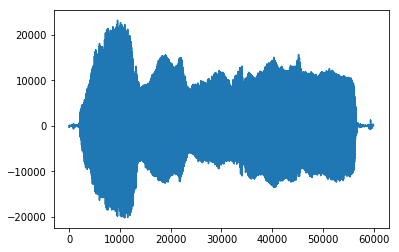

In [2]:
sound = 'aeiou.wav'
rate, frames = wavfile.read(sound)
plt.plot(frames)
idp.Audio(frames, rate=rate)

In [18]:
def nextpow2(x):
    assert x>0
    p = np.ceil(np.log2(x))
    x_ = 2**p
    assert 2**(p-1) < x <= x_
    return p

def period(x, Fs, Pmin=1/300, Pmax=1/80, seuil=0.7) :
    # [P,voiced] = period(x,Fs,Pmin,Pmax,seuil);
    # If voiced = 1, P is the period signal x expressed in number of samples
    # If voiced = 0, P is equal to 10ms.Fs

    x = x - np.mean(x)
    N = len(x)

    Nmin = 1 + np.ceil(Pmin*Fs).astype(int)
    Nmax = 1 + np.floor(Pmax*Fs).astype(int)
    Nmax = np.min([Nmax,N])

    Nfft = int(2**nextpow2(2*N-1))
    X = np.fft.fft(x, n=Nfft)
    S = X * np.conj(X) / N
    r = np.real(np.fft.ifft(S))

    rmax = np.max(r[Nmin:Nmax])
    I = np.argmax(r[Nmin:Nmax])
    P = I+Nmin
    corr = (rmax/r[0]) * (N/(N-P))
    voiced = corr > seuil
    if not voiced :
        P = np.round(10e-3*Fs)

    return P,voiced

## 1 - Extraction of the analysis marks

In [30]:
def AnalysisPitchMarks(s, rate):
    """
    Extracts the analysis marks
    s : the signal to be analysed 
    rate : the sampling frequency 
    Returns a matrix A that contains the times and pitches corresponding to each analysis mark. 
    """
    t_a = [1]   # t_a[0] = 1
    voiced = [0]
    P_a = [0.01 * rate]  #P_a[0] = 10ms*rate (unvoiced)

    while True:
        t = t_a[-1]
        P = P_a[-1]
        T = floor(2.5 * P)  

        if t + T <= len(s):
            x = s[int(t):int(t + T)]
            P, v = period(x, rate)
            voiced.append(v)
            P_a.append(P)
            t_a.append(t + P)
        else:
            break 
            
    A = np.zeros((3, len(t_a)))
    A[0,:] = t_a
    A[1,:] = voiced
    A[2,:] = P_a

    return A

In [91]:
A = AnalysisPitchMarks(frames, rate)

## 2 - Synthesis and modification of the temporal and spectral scales

In [33]:
B = np.zeros((2, m))
B[0,:] = A[0,:]  #t_s(:)
B[1,:] = np.arange(m)  #[1,2,3,...]


### 2.1 - Signal Synthesis

In [34]:
def Synthesis(s, A, B):
    k_end = int(B[0,-1])
    n_k_end = int(B[1,-1])
    n = int(k_end + A[2, n_k_end]) + 1 # t_s(k_end) + P_a(n(k_end))
    y = np.zeros(n)
    u,v = B.shape
    for i in range(1,v):
        k = B[1,i]
        t_a = int(A[0,int(k)])
        P_a = int(A[2,int(k)])
        t_s = int(B[0,i])
        x = s[t_a-P_a:t_a+P_a+1]
        x = x * np.hanning(2*P_a+1)
        y[t_s-P_a:t_s+P_a+1] += x
    return y

In [35]:
y = Synthesis(frames, A, B)

### 2.2 - Modification of the temporal scale 

In [63]:
def ChangeTimeScale(alpha, A):
    t_s = [1]
    n = [0,1]
    _,m = A.shape
    while int(n[-1]) < m:
        t = t_s[-1] + A[2,int(n[-1])]
        t_s.append(t)
        
        n_k = n[-1] + 1/alpha 
        n.append(n_k)
        
    B = np.zeros((2, len(t_s)))
    B[0,:] = np.array(t_s, dtype=int)
    B[1,:] = np.array(n[:-1], dtype=int)
    return B
        
    

(2, 354)


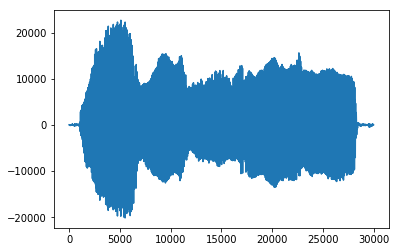

In [79]:
# Accelerate time scale
B = ChangeTimeScale(0.5,A)
print(B.shape)
y = Synthesis(frames, A, B)
plt.plot(y)
idp.Audio(y, rate=rate)

(2, 1411)


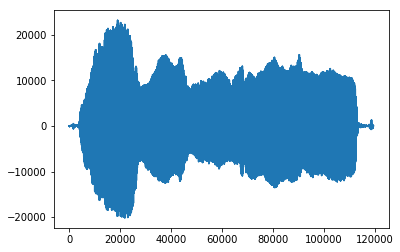

In [65]:
# Prolongate time scale
B = ChangeTimeScale(2,A)
print(B.shape)
y = Synthesis(frames, A, B)
plt.plot(y)
idp.Audio(y, rate=rate)

> The function seems to work well. We manage to prolongate or shorten the time scale without influencing the pitch. 

### 2.3 - Modification of the spectral scale 

In [41]:
def ChangePitchScale(beta, A):
    scale = [1/beta if A[1,0] else 1]
    t_s = [1]
    n = [0, scale[0]]
    _,m = A.shape
    while int(n[-1]) < m:
        scale.append(1/beta if A[1,int(n[-1])] else 1)
        
        t = t_s[-1] + scale[-1] * A[2, int(n[-1])]
        t_s.append(t)
        
        n_k = n[-1] + scale[-1]
        n.append(n_k)
    
    B = np.zeros((2, len(t_s)))
    B[0,:] = np.array(t_s, dtype=int)
    B[1,:] = np.array(n[:-1], dtype=int)
    return B

(2, 1364)


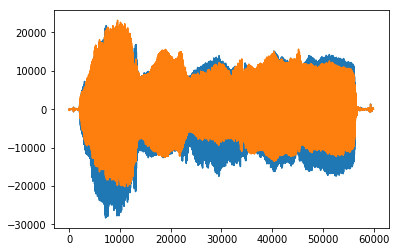

In [57]:
B = ChangePitchScale(2,A)
print(B.shape)
y = Synthesis(frames, A, B)
plt.plot(y)
plt.plot(frames)
idp.Audio(y, rate=rate)

> In blue the new signal, and in orange the original one. 

(2, 375)


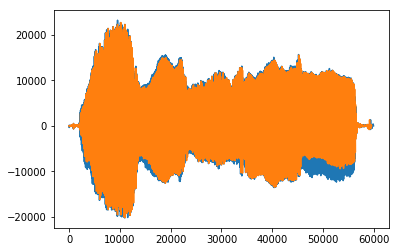

In [56]:
B = ChangePitchScale(0.5,A)
print(B.shape)
y = Synthesis(frames, A, B)
plt.plot(frames)
plt.plot(y)
idp.Audio(y, rate=rate)

> In blue the original signal, and in orange the new one. 

> We notice that the function works well because we manage to change the spectral scale without changing the time scale. 

### 2.4 - Joint modification of the temporal and spectral scales 

In [154]:
def ChangeBothScales(alpha, beta, A):
    scale = [1/beta if A[1,0] else 1]
    t_s = [1]
    n = [0, scale[0]]
    _,m = A.shape

    while int(n[-1]) < m:
        scale.append(1/beta if A[1,int(n[-1])] else 1)
        
        t = t_s[-1] + scale[-1] * A[2, int(n[-1])] 
        t_s.append(t)

        n_k = n[-1] + scale[-1]/alpha
        n.append(n_k)
    
    B = np.zeros((2, len(t_s)))
    B[0,:] = np.array(t_s, dtype=int)
    B[1,:] = np.array(n[:-1], dtype=int)
    return B


(2, 753)


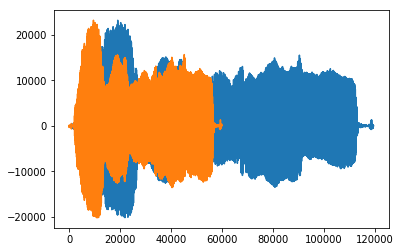

In [155]:
B = ChangeBothScales(2,0.5,A)
print(B.shape)
y = Synthesis(frames, A, B)
plt.plot(y)
plt.plot(frames)
idp.Audio(y, rate=rate)


(2, 682)


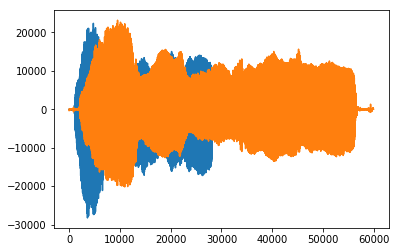

In [156]:
B = ChangeBothScales(0.5,2,A)
print(B.shape)
y = Synthesis(frames, A, B)
plt.plot(y)
plt.plot(frames)
idp.Audio(y, rate=rate)

(2, 2727)


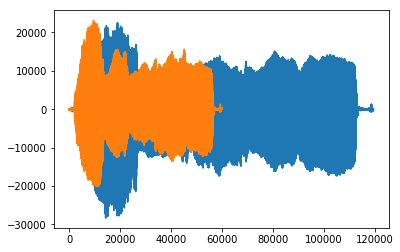

In [157]:
B = ChangeBothScales(2,2,A)
print(B.shape)
y = Synthesis(frames, A, B)
plt.plot(y)
plt.plot(frames)
idp.Audio(y, rate=rate)

(2, 188)


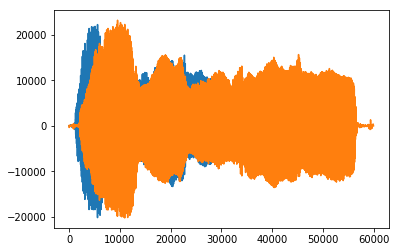

In [159]:
B = ChangeBothScales(0.5,0.5,A)
print(B.shape)
y = Synthesis(frames, A, B)
plt.plot(y)
plt.plot(frames)
idp.Audio(y, rate=rate)

> For all the previous plots, in orange the original signal and in blue the new one. 

> In this last function, we can modify the pitch and the time scale at the same time